## Final Project Submission

Please fill out:
* Student name: Robin


# TOC
* [Imports and file reading](#imports)
* [Preproccesing: Data Cleaning](#preprocessing)
* [Data description and visualization](#descriptivestats)
* [Data fitting / statistical model](#CellHPDist)
* [Conclusions](*conclusions)
* [Business case](*businesscase)

<a href="#imports"></a>

In [226]:
%matplotlib inline
# Pandas and numpy for data handling
import pandas as pd
import numpy as np
from scipy import stats

# Statsmodels for fitting
import statsmodels.api as sm

# Plotting tools
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import matplotlib.gridspec as gridspec
import matplotlib.style as style
style.use('fivethirtyeight')

# Folium for map plotting
import folium
from folium.plugins import HeatMap

In [129]:
# Set plot style

In [343]:
# Read House Price data
df = pd.read_csv('King_County_House_prices_dataset.csv', parse_dates=True)
# Create a copy of the original dataframe in order to always have access to
# the pristine data
df_back = df.copy()

In [168]:
# Run regex filter from Regex_Filter.ipynb notebook
%run Regex_Filter.ipynb

In [132]:
# Check that data has been successfully loaded
df.head(10)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
5,7237550310,5/12/2014,1230000.0,4,4.50,5420,101930,1.0,0.0,0.0,...,11,3890,1530.0,2001,0.0,98053,47.6561,-122.005,4760,101930
6,1321400060,6/27/2014,257500.0,3,2.25,1715,6819,2.0,0.0,0.0,...,7,1715,?,1995,0.0,98003,47.3097,-122.327,2238,6819
7,2008000270,1/15/2015,291850.0,3,1.50,1060,9711,1.0,0.0,NaN,...,7,1060,0.0,1963,0.0,98198,47.4095,-122.315,1650,9711
8,2414600126,4/15/2015,229500.0,3,1.00,1780,7470,1.0,0.0,0.0,...,7,1050,730.0,1960,0.0,98146,47.5123,-122.337,1780,8113
9,3793500160,3/12/2015,323000.0,3,2.50,1890,6560,2.0,0.0,0.0,...,7,1890,0.0,2003,0.0,98038,47.3684,-122.031,2390,7570


<a href="#preprocessing"></a>
# Preproccesing: Data Cleaning

Lets check how much data we have to work with.

In [133]:
df.shape

(21597, 21)

We have information on 21597 houses in the data set. The dataset consists of 21 columns. To gain insight on possible feautures of interest, lets look at the column names and their respective descriptions from the supplied 'column_names.md' file. 

In [136]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

Read in the column description file and save the descriptions into a variable.

In [138]:
f = open('column_names.md', 'r')
col_desc = f.read()
print(col_desc)

# Column Names and descriptions for Kings County Data Set
* **id** - unique identified for a house
* **dateDate** - house was sold
* **pricePrice** -  is prediction target
* **bedroomsNumber** -  of Bedrooms/House
* **bathroomsNumber** -  of bathrooms/bedrooms
* **sqft_livingsquare** -  footage of the home
* **sqft_lotsquare** -  footage of the lot
* **floorsTotal** -  floors (levels) in house
* **waterfront** - House which has a view to a waterfront
* **view** - Has been viewed
* **condition** - How good the condition is ( Overall )
* **grade** - overall grade given to the housing unit, based on King County grading system
* **sqft_above** - square footage of house apart from basement
* **sqft_basement** - square footage of the basement
* **yr_built** - Built Year
* **yr_renovated** - Year when house was renovated
* **zipcode** - zip
* **lat** - Latitude coordinate
* **long** - Longitude coordinate
* **sqft_living15** - The square footage of interior housing living space for the neares

'price' is the predicted variable, hence we have 20 potential feautures to evaluate. The unique 'id' variable can be exluded as it is very unlikely it will have an inmpact on the sale price.

In [134]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,19221.000000,21534.000000,21597.000000,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.007596,0.233863,3.409825,7.657915,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.086825,0.765686,0.650546,1.173200,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [9]:
df.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront       float64
view             float64
condition          int64
grade              int64
sqft_above         int64
sqft_basement     object
yr_built           int64
yr_renovated     float64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

The 'sqft_basement' is of 'object' datatype, although all other 'sqft_' columns are floats. This is an indication that the column might contain non-numerical values. We will come back to this topic a little later. First, lets look into data conistency / missing values.

In [293]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


All columns except for 'waterfront', 'view', and 'yr_renovated' have 21597 values, meaning that they contain no missing values, as is also illustrated by the following:

In [141]:
df.isnull().sum().sort_values(ascending=False)

yr_renovated     3842
waterfront       2376
view               63
sqft_lot15          0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
condition           0
sqft_living15       0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
zipcode             0
lat                 0
long                0
id                  0
dtype: int64

In [31]:
df.isna().sum().sort_values(ascending=False)

yr_renovated         3842
waterfront           2376
view                   63
sqft_basement_rec       0
date                    0
price                   0
bedrooms                0
bathrooms               0
sqft_living             0
sqft_lot                0
floors                  0
condition               0
sqft_lot15              0
grade                   0
sqft_above              0
sqft_basement           0
yr_built                0
zipcode                 0
lat                     0
long                    0
sqft_living15           0
id                      0
dtype: int64

We have missing values in three categories: yr_renovated, waterfront, and view. 

Lets calculate the percentage of missing values for each individual column.

In [32]:
missing_vals = df.isna().sum().sort_values(ascending=False)
missing_vals_per = df.isna().sum().sort_values(ascending=False)/len(df)
missing_vals_overview = pd.concat([missing_vals, missing_vals_per], axis=1)
missing_vals_overview.columns = ['total', 'percent']
missing_vals_overview

,total,percent
yr_renovated,3842,0.177895
waterfront,2376,0.110015
view,63,0.002917
sqft_basement_rec,0,0.000000
date,0,0.000000
price,0,0.000000
bedrooms,0,0.000000
bathrooms,0,0.000000
sqft_living,0,0.000000
sqft_lot,0,0.000000


yr_renovated has 18% missing values, waterfront has 11% missing values and "view" has 0.3% missing values

### The 'id' feature
The id feature isn't really a feature. It is an unique identifier used to indefy the houses.

#### The 'date' feature
Turn date column into datetime object. And create seperate columns for 'year', 'month', and 'day'.

In [309]:
import datetime as dt

In [398]:
df['date'] = pd.to_datetime(df['date'])
df['year'] = [x.year for x in df['date']]
df['month'] = [x.month for x in df['date']]
df['day'] = [x.day for x in df['date']]
df['month'].value_counts()

5     2414
4     2229
7     2211
6     2178
8     1939
10    1876
3     1875
9     1771
12    1470
11    1409
2     1247
1      978
Name: month, dtype: int64

#### The 'yr_renovated' feature

In [219]:
df['yr_renovated'].value_counts().head()

0.0       17011
2014.0       73
2003.0       31
2013.0       31
2007.0       30
Name: yr_renovated, dtype: int64

The vast majority (97%) of the properties have either a missing value or 0 value in the 'yr_renovated' feature. Also, it is not known from the description file how much renovation is required for this value to be updated. Given the distribution of the 'yr_built' feature (1900-2015) it appears unlikely, that only 3% of the sold houses had been renovated before the time of sale.

Hence, this feature will be ignored in the feature analysis.

In [401]:
df['yr_renovated'].fillna(value=0, inplace=True)
#df.drop('yr_renovated', inplace=True, axis=1)

In [355]:
print(df[df['yr_renovated'] == 0.0]['condition'].value_counts())
print(df[df['yr_renovated'] > 0.0]['condition'].value_counts())

print(df[df['yr_renovated'] == 0.0]['price'].median())
print(df[df['yr_renovated'] > 0.0]['price'].median())

3    10922
4     4540
5     1386
2      141
1       22
Name: condition, dtype: int64
3    603
4    106
5     31
2      3
1      1
Name: condition, dtype: int64
447500.0
607502.0


#### The 'condition' feature

In [340]:
print('NaN value count: ', sum(df['condition'].isna()))
print(df['condition'].value_counts())

NaN value count:  0
3    14020
4     5677
5     1700
2      170
1       29
Name: condition, dtype: int64


#### The 'grade' feature

In [341]:
print('NaN value count: ', sum(df['grade'].isna()))
print(df['grade'].value_counts())

NaN value count:  0
7     8973
8     6065
9     2615
6     2038
10    1134
11     399
5      242
12      89
4       27
13      13
3        1
Name: grade, dtype: int64


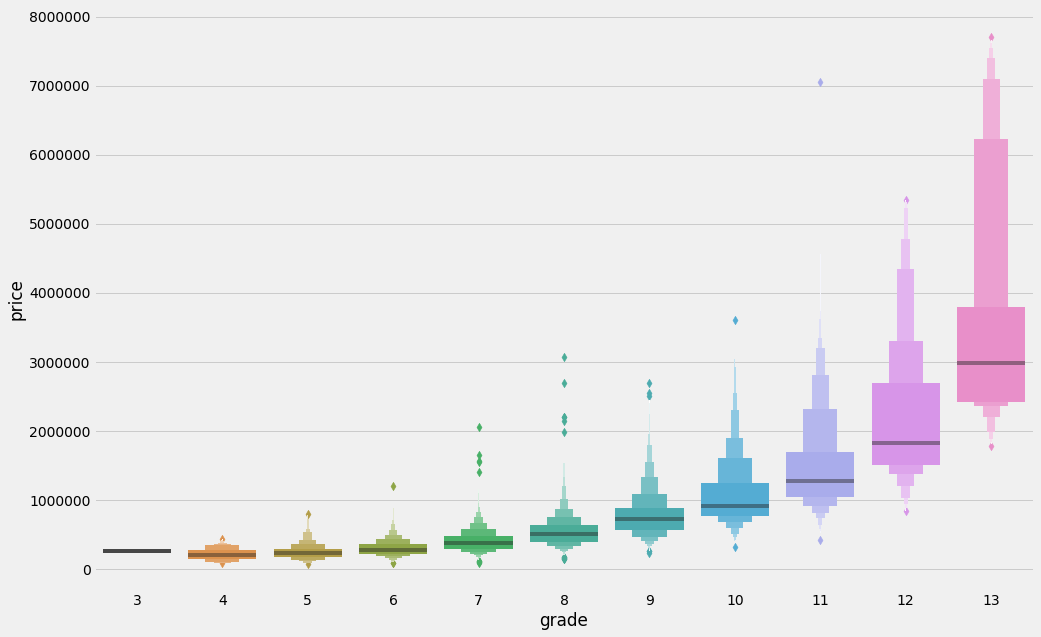

In [333]:
fig = plt.figure(figsize=(15,10))
sns.boxenplot(x='grade', y='price', data=df)

#### The 'waterfront' feature

In [200]:
df['waterfront'].value_counts()

0.0    19075
1.0      146
Name: waterfront, dtype: int64

Only 0.7% of the houses have a waterfront view. However, also 11% of values are missing. To dig a little deeper, we can create a map showing the location (using the 'lat' and 'long' features) of the houses.

In [356]:
m4 = folium.Map([47.608013, -122.335167], zoom_start=11)
m4.add_child(HeatMap(
    df[['lat', 'long']][df['waterfront'].isna()],
    radius=4,
    blur=1), name='Map of properties with missing value for waterfront feature')
m4

The map reveals that the majority of properties probably have no view of a waterfront given their location. However, it is quite difficult to come to an definete conclusion. It might be best to completely ignore the waterfront feature. However, in order to be able to test a linear regression model, we will for now will them NaNs with zeros.

In [394]:
df['waterfront'].fillna(value=0, inplace=True)

#### The 'view' feature

In [229]:
df['view'].value_counts()

0.0    19422
2.0      957
3.0      508
1.0      330
4.0      317
Name: view, dtype: int64

Considering the given data, we could come to the conclusion that 90% of the houses sold have not been viewed at least one single time before being sold. Given that the purchase of a house is typically not an everyday task, the aforementioned seems highly unlikely. Again the quality of data must be doubted. For now though, we are not going to exclude this feature completely. Like for the 'waterfront' feature, we will for now fill the NaN values with zeros.

In [396]:
df['view'].fillna(value=0, inplace=True)

#### The 'bathrooms' and 'bedrooms' features.

In [238]:
df['bathrooms'].value_counts()

2.50    5377
1.00    3851
1.75    3048
2.25    2047
2.00    1930
1.50    1445
2.75    1185
3.00     753
3.50     731
3.25     589
3.75     155
4.00     136
4.50     100
4.25      79
0.75      71
4.75      23
5.00      21
5.25      13
5.50      10
1.25       9
6.00       6
5.75       4
0.50       4
8.00       2
6.25       2
6.75       2
6.50       2
7.50       1
7.75       1
Name: bathrooms, dtype: int64

In [239]:
df[df['bathrooms'] == 7.75]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,sqft_basement_rec
9245,9208900037,9/19/2014,6890000.0,6,7.75,9890,31374,2.0,0.0,4.0,...,13,8860,1030.0,2001,98039,47.6305,-122.24,4540,42730,1030.0


In [237]:
df['bedrooms'].value_counts()

3     9824
4     6882
2     2760
5     1601
6      272
1      196
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

33 bedrooms seems like a very large number. Lets look into this particular property.

In [242]:
df[df['bedrooms'] == 33]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,sqft_basement_rec
15856,2402100895,6/25/2014,640000.0,33,1.75,1620,6000,1.0,0.0,0.0,...,7,1040,580.0,1947,98103,47.6878,-122.331,1330,4700,580.0


In [244]:
print(df['price'].median(), df['sqft_living'].median())

450000.0 1910.0


Considering the fact that the sale price of 640,00USD is only slightly higher than the average price of 450,000USD and the living area of 1620sqft is lower than the average living space of 1620sqft, it is likely the value of 33 bedrooms is a data entry error. Considering the large overall size of the dataset, it is save to delete this record. 

In [247]:
#df.drop(index=15856, inplace=True)

#### The 'sqft_basement' feature
As mentioned above, 'sqft_basement' datatype is object, indicating that some of the values might be non-numerical.

In [143]:
df['sqft_basement'].head(10)

0       0.0
1     400.0
2       0.0
3     910.0
4       0.0
5    1530.0
6         ?
7       0.0
8     730.0
9       0.0
Name: sqft_basement, dtype: object

I wrote the filter_and_return() function to return all non-numerical values in given column in a separate dataframe

In [170]:
result = filter_and_return(data=df, col='sqft_basement', type='float')

In [171]:
result.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
6,1321400060,6/27/2014,257500.0,3,2.25,1715,6819,2.0,0.0,0.0,...,7,1715,?,1995,0.0,98003,47.3097,-122.327,2238,6819
18,16000397,12/5/2014,189000.0,2,1.00,1200,9850,1.0,0.0,0.0,...,7,1200,?,1921,0.0,98002,47.3089,-122.210,1060,5095
42,7203220400,7/7/2014,861990.0,5,2.75,3595,5639,2.0,0.0,0.0,...,9,3595,?,2014,0.0,98053,47.6848,-122.016,3625,5639
79,1531000030,3/23/2015,720000.0,4,2.50,3450,39683,2.0,0.0,0.0,...,10,3450,?,2002,0.0,98010,47.3420,-122.025,3350,39750
112,2525310310,9/16/2014,272500.0,3,1.75,1540,12600,1.0,0.0,0.0,...,7,1160,?,1980,0.0,98038,47.3624,-122.031,1540,11656


There appear to be some '?'-characters in the 'sqft_basement' column. Lets see how many:

In [152]:
print('Number of \'?\'-characters: ', sum([x == '?' for x in result['sqft_basement']]))

Number of '?'-characters:  454


The '?' character appears 454 in the column. Lets compare it to the length of the entire dataframe:

In [154]:
print('Number of rows with non-numerical characters: ', len(result['sqft_basement']))

Number of rows with non-numerical characters:  454


All of the non-numerical values appear to be '?'. What are the implications? To figure this out, lets look into the columns which have numerical values. Lets see, whether we can reconstruct the sqft_basement from the sqft_above and sqft_living columns.

In [197]:
df_clean = df[df['sqft_basement'] != '?'].copy()
print('Number of rows in which do not contain a \'?\' in the sqft_basement column: ', len(df_clean))
cons_check = df_clean[(df_clean['sqft_living'] - df_clean['sqft_above']) == df_clean['sqft_basement'].astype(np.float64)]
print('Number of rows where sqft_living equals sum of sqft_above and sqft_basement: ', len(cons_check)) 

Number of rows in which do not contain a '?' in the sqft_basement column:  21143
Number of rows where sqft_living equals sum of sqft_above and sqft_basement:  21143


sqft_basement can be reconstructed from sqft_living and sqft_above, so lets do this for the rows containing a '?' character.

In [362]:
df['sqft_basement_rec'] = [x.replace('?', '0.0') for x in df['sqft_basement']]
df['sqft_basement_rec'] = df['sqft_basement_rec'].astype(np.float64)
df['sqft_basement_rec'].head()

0      0.0
1    400.0
2      0.0
3    910.0
4      0.0
Name: sqft_basement_rec, dtype: float64

#### The 'sqft_lot15' and 'sqft_living15' features
The two features aim to estimate the impact the neighbourhood has on the sale prices by. The average lot size and living size of the 15 nearest neighbours are given.

In [569]:
perc1 = len(df[df['sqft_living'] == df['sqft_living15']])/len(df)*100
print('Percentage of records where \'sqft_living15\' matches \'sqft_living\': {:.2f} %'.format(perc1))

perc2 = len(df[df['sqft_lot'] == df['sqft_lot15']])/len(df)*100
print('Percentage of records where \'sqft_lot15\' matches \'sqft_lot\': {:.2f} %'.format(perc2))

df[(df['sqft_living'] == df['sqft_living15']) | (df['sqft_lot'] == df['sqft_lot15'])].shape

Percentage of records where 'sqft_living15' matches 'sqft_living': 11.87 %
Percentage of records where 'sqft_lot15' matches 'sqft_lot': 20.72 %
20.7158401629856


(6518, 26)

For 30% of all records either the 'sqft_living' value matches the 'sqft_living15' value, or the 'sqft_lot' matches the 'sqft_lot15' value. This raises doubts concerning the usability of the the 'sqft_living15' and 'sqft_lot15' features. In case of the 'sqft_living' this might be from big residential complexes with many flats / houses of the same size. Lets map these things out to see whether this might help gaining insight. 

In [572]:
m2 = folium.Map([47.608013, -122.335167], zoom_start=11)
m2.add_child(HeatMap(
    df[['lat', 'long']][df['sqft_living'] == df['sqft_living15']],
    radius=4,
    blur=1), name='')
m2.add_child(HeatMap(
    df[['lat', 'long']][df['sqft_lot'] == df['sqft_lot15']],
    radius=4,
    blur=1), name='')
m2

This doesn't really help. Well try an build a model without the 'sqft_living15' and 'sqft_lot15' features.

<a id="descriptivestats"></a>
# Data description and visualization

//anaconda3/envs/nf/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


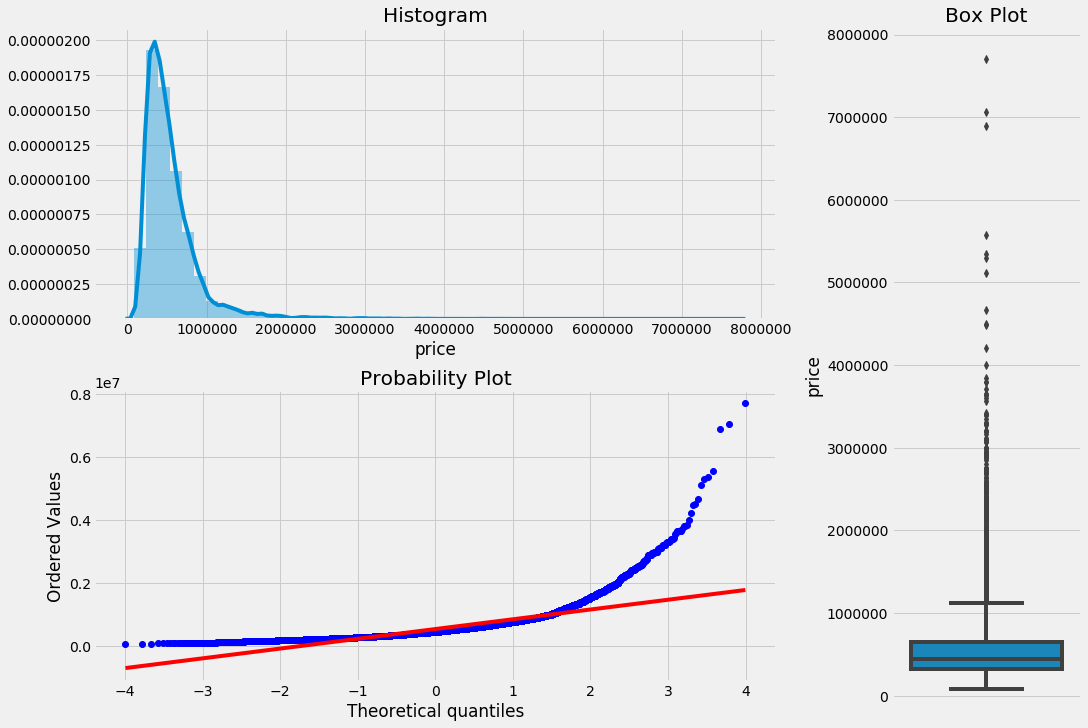

In [250]:
fig = plt.figure(constrained_layout=True, figsize=(15,10))
grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)

ax1 = fig.add_subplot(grid[0, :2])
ax1.set_title('Histogram')
sns.distplot(df['price'], norm_hist=False, ax = ax1)

ax2 = fig.add_subplot(grid[1, :2])
ax2.set_title('QQ_plot')
stats.probplot(df['price'], plot = ax2)

ax3 = fig.add_subplot(grid[:, 2])
ax3.set_title('Box Plot')
sns.boxplot(df['price'], orient='v', ax = ax3 );

In [139]:
print('Skewness {}'.format(df['price'].skew()))
print('Kurtosis {}'.format(df['price'].kurt()))

Skewness 4.023364652271239
Kurtosis 34.54135857673376


A skewnewss value between [-2, 2] is considered acceptable.

//anaconda3/envs/nf/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


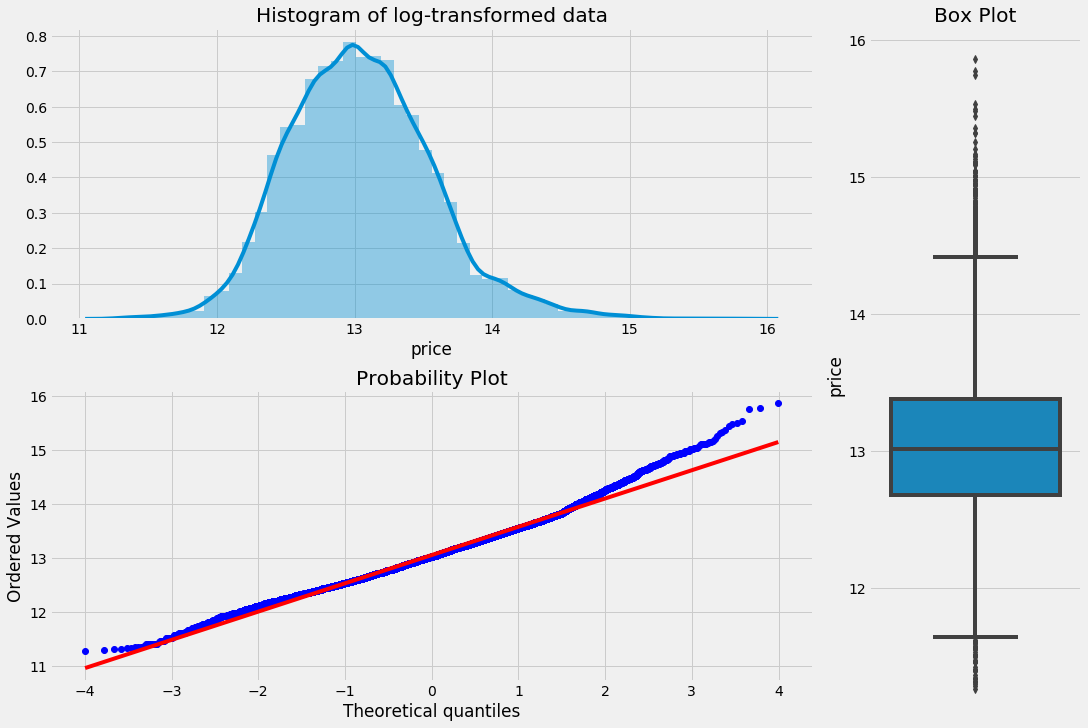

In [255]:
log_price = np.log(df['price'])
fig = plt.figure(constrained_layout=True, figsize=(15,10))
grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)

ax1 = fig.add_subplot(grid[0, :2])
ax1.set_title('Histogram of log-transformed data')
sns.distplot(log_price, norm_hist=False, ax = ax1)

ax2 = fig.add_subplot(grid[1, :2])
ax2.set_title('QQ_plot')
stats.probplot(log_price, plot = ax2)

ax3 = fig.add_subplot(grid[:, 2])
ax3.set_title('Box Plot')
sns.boxplot(log_price, orient='v', ax = ax3 );

In [258]:
print('Skewness after log-transform: {}'.format(log_price.skew()))
print('Kurtosis after log-transform: {}'.format(log_price.kurt()))

Skewness after log-transform: 0.43107952959103885
Kurtosis after log-transform: 0.6910469577374965


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5]), <a list of 24 Text xticklabel objects>)

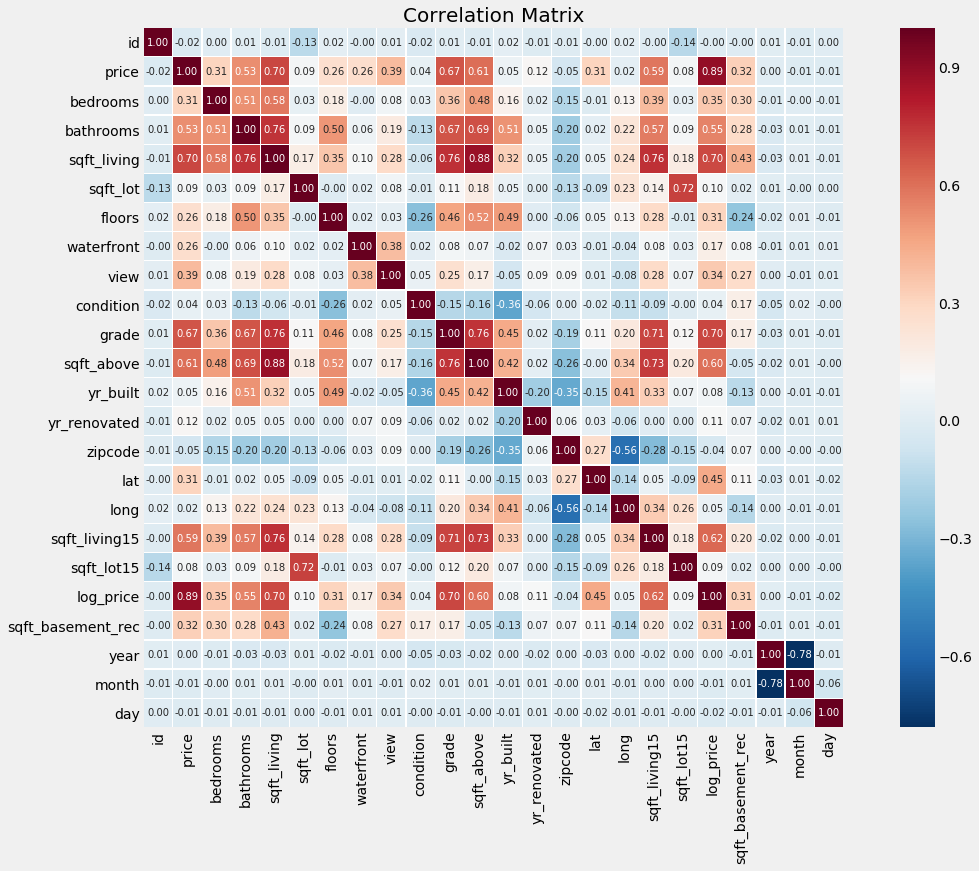

In [573]:
df['log_price'] = log_price
plt.figure(figsize=(18,12))
plt.title('Correlation Matrix', fontsize=20)
sns.heatmap(df.corr(), cmap='RdBu_r', square=True,
            annot=True, fmt='.2f', annot_kws={'size': 10}, 
            linewidths=0.25, linecolor='w')
plt.xticks(rotation=90)

In [381]:
df.corr()['price'].sort_values(ascending=False)

price                1.000000
log_price            0.891746
sqft_living          0.701917
grade                0.667951
sqft_above           0.605368
sqft_living15        0.585241
bathrooms            0.525906
view                 0.395734
sqft_basement_rec    0.321108
bedrooms             0.308787
lat                  0.306692
waterfront           0.276295
floors               0.256804
yr_renovated         0.129599
sqft_lot             0.089876
sqft_lot15           0.082845
yr_built             0.053953
condition            0.036056
long                 0.022036
id                  -0.016772
zipcode             -0.053402
Name: price, dtype: float64

In [260]:
df.corr()['log_price'].sort_values(ascending=False)

log_price            1.000000
price                0.891746
grade                0.703747
sqft_living          0.695209
sqft_living15        0.619371
sqft_above           0.601621
bathrooms            0.551270
lat                  0.448824
bedrooms             0.350871
view                 0.345478
sqft_basement_rec    0.313106
floors               0.310665
waterfront           0.180529
sqft_lot             0.100032
sqft_lot15           0.092290
yr_built             0.080608
long                 0.050887
condition            0.038855
id                  -0.003730
zipcode             -0.038801
Name: log_price, dtype: float64

In [597]:
df['log_price'].fillna(value=0, inplace=True)

## Exploring and visualizing the data
Lets plot scatter matrix plots of the top eight features from the correlation tables above.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c42142e48>,
      dtype=object)

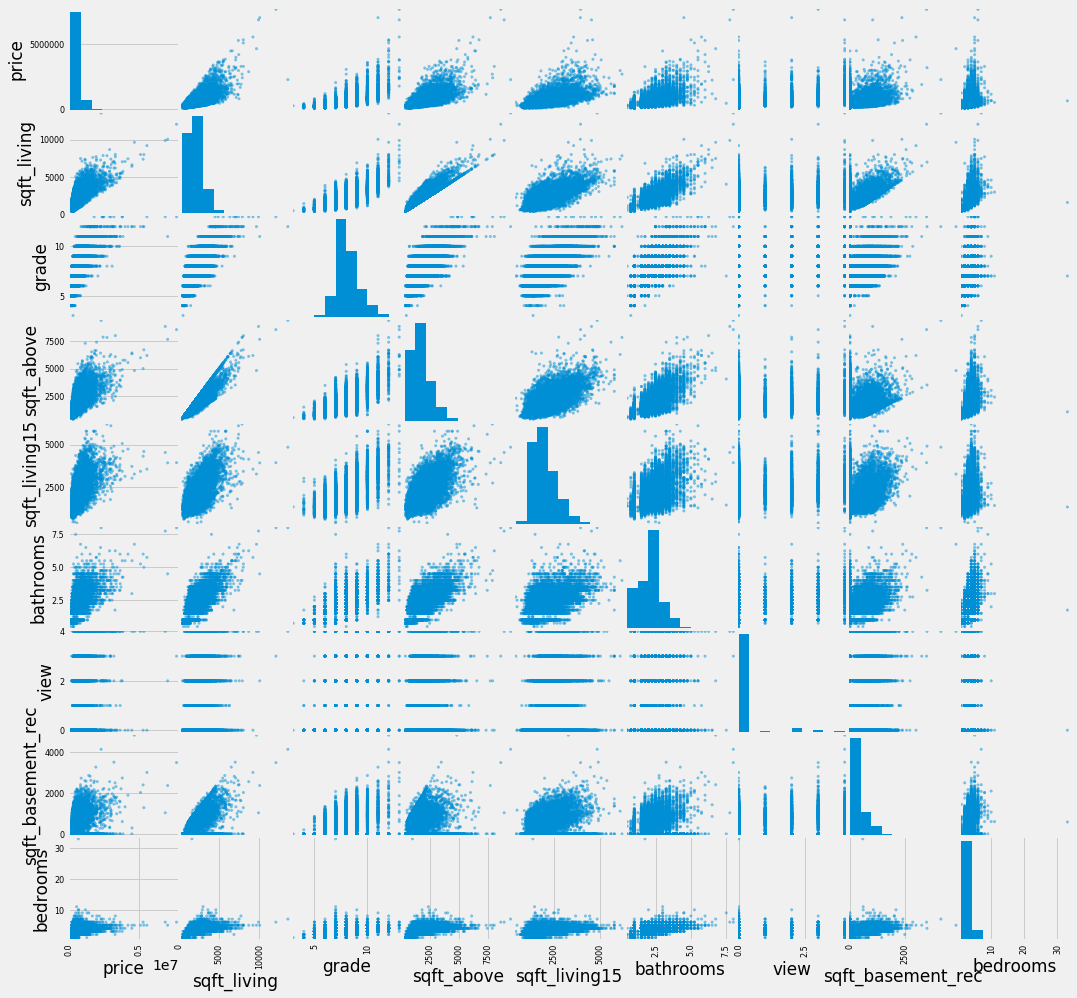

In [586]:
top_features = ['price']+['sqft_living', 'grade', 'sqft_above', 'sqft_living15', 'bathrooms', 'view', 'sqft_basement_rec', 'bedrooms']

scatter_matrix(df[top_features], figsize=(16,16))

<a href='CellHPDist'></a>
# Data fitting / statistical model
## Simple Linear Regressions

In [649]:
#Lets start with 

list_of_r2 =[]
print('------------------------------------------\n\n')
print('Fitting results (R2-values) for simple linear regression \nfor all independent variables with \'price\'\n')
print('------------------------------------------\n')
for col in df.columns:
    if col not in ['price', 'log_price', 'id', 'date', 'sqft_basement', ]:
        X = df[col]
        X = sm.add_constant(X)
        Y = df['price']
        model = sm.OLS(Y, X)
        result = model.fit()
        list_of_r2.append((result.rsquared, col))
        
for idx, el in enumerate(sorted(list_of_r2, reverse=True)):
    print('{}. Independent variable: \'{}\'; dependent variable \'price\'; R2-value: {:.4f}'.format(idx+1, el[1], el[0]))

------------------------------------------


Fitting results (R2-values) for simple linear regression 
for all independent variables with 'price'

------------------------------------------

1. Independent variable: 'grade_perprice'; dependent variable 'price'; R2-value: 0.4948
2. Independent variable: 'sqft_living'; dependent variable 'price'; R2-value: 0.4927
3. Independent variable: 'grade'; dependent variable 'price'; R2-value: 0.4462
4. Independent variable: 'sqft_above'; dependent variable 'price'; R2-value: 0.3665
5. Independent variable: 'sqft_living15'; dependent variable 'price'; R2-value: 0.3425
6. Independent variable: 'bathrooms_perusd'; dependent variable 'price'; R2-value: 0.2921
7. Independent variable: 'bathrooms'; dependent variable 'price'; R2-value: 0.2766
8. Independent variable: 'sqftliving_perprice'; dependent variable 'price'; R2-value: 0.2339
9. Independent variable: 'view'; dependent variable 'price'; R2-value: 0.1548
10. Independent variable: 'sqft_basement_r

The best R2-value in SLR is obtained for 'sqft_living' with 'price'.

## Multiple linear regression with 'top five features'

In [648]:
features = ['sqft_living', 'grade', 'sqft_above', 'bathrooms', 'view']
Y = df['price']
X = df[features]
X = sm.add_constant(X)

model = sm.OLS(Y, X)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.575
Model:                            OLS   Adj. R-squared:                  0.575
Method:                 Least Squares   F-statistic:                     5854.
Date:                Mon, 04 Nov 2019   Prob (F-statistic):               0.00
Time:                        08:00:40   Log-Likelihood:            -2.9814e+05
No. Observations:               21597   AIC:                         5.963e+05
Df Residuals:                   21591   BIC:                         5.963e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -5.811e+05   1.32e+04    -44.002      0.000   -6.07e+05   -5.55e+05
sqft_living   209.9621      4.331     48.480      0.000     201.473     218.451
grade        1.049e+05   2298.775     45.635      0.000       1e+05    1.09e+05
sqft_above    -42.6067      4.346     -9.804      0.000     -51.125     -34.089
bathrooms   -3.016e+04   3314.558     -9.099      0.000   -3.67e+04   -2.37e+04
view         9.124e+04   2272.076     40.156      0.000    8.68e+04    9.57e+04
==============================================================================
Omnibus:                    16739.041   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1126773.484
Skew:                           3.188   Prob(JB):                         0.00
Kurtosis:                      37.806   Cond. No.                     2.46e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.46e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The R2-value of .575 is pretty low. Lets try and improve our model.

In [ ]:
#form = 'price ~ sqft_living + grade + sqft_above  + bathrooms + view'
#form = 'price ~ sqft_living + grade + sqft_above + sqft_living15 + bathrooms'
#form = 'price ~ C(grade) + bathrooms + sqft_living + view + sqft_above + sqft_living15'
#form1 = 'price ~ sqft_basement_rec + sqft_living + sqft_lot + floors '

### Adding categorical variables

#### 'grade' as categorical variable

In [651]:
df_grade_dummy = pd.get_dummies(df['grade'], prefix='grade', drop_first=True)
df_grade = pd.concat([df[features], df_grade_dummy], axis=1)

# Construct features list with categorical variables
grade_dummy = list(df_grade_dummy.columns)
features = ['sqft_living', 'sqft_above', 'bathrooms', 'view']
features_grade = [x for x in df_grade.columns if x in features or x in grade_dummy]

Y = df['price']
X = df_grade[features_grade]
X = sm.add_constant(X)

model = sm.OLS(Y, X)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.617
Method:                 Least Squares   F-statistic:                     2484.
Date:                Mon, 04 Nov 2019   Prob (F-statistic):               0.00
Time:                        08:08:28   Log-Likelihood:            -2.9703e+05
No. Observations:               21597   AIC:                         5.941e+05
Df Residuals:                   21582   BIC:                         5.942e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        2.014e+05   2.27e+05      0.886      0.376   -2.44e+05    6.47e+05
sqft_living   185.6527      4.153     44.704      0.000     177.513     193.793
sqft_above    -61.6459      4.191    -14.709      0.000     -69.860     -53.431
bathrooms   -5179.4674   3230.822     -1.603      0.109   -1.15e+04    1153.183
view         8.217e+04   2171.827     37.834      0.000    7.79e+04    8.64e+04
grade_4     -8.175e+04   2.32e+05     -0.353      0.724   -5.36e+05    3.72e+05
grade_5     -8.264e+04   2.28e+05     -0.363      0.717   -5.29e+05    3.64e+05
grade_6       -5.6e+04   2.27e+05     -0.246      0.806   -5.02e+05     3.9e+05
grade_7     -2.435e+04   2.27e+05     -0.107      0.915    -4.7e+05    4.21e+05
grade_8      4.302e+04   2.27e+05      0.189      0.850   -4.03e+05    4.89e+05
grade_9       1.76e+05   2.28e+05      0.774      0.439    -2.7e+05    6.22e+05
grade_10     3.716e+05   2.28e+05      1.632      0.103   -7.47e+04    8.18e+05
grade_11     6.526e+05   2.28e+05      2.863      0.004    2.06e+05     1.1e+06
grade_12      1.16e+06   2.29e+05      5.063      0.000    7.11e+05    1.61e+06
grade_13     2.368e+06   2.37e+05     10.002      0.000     1.9e+06    2.83e+06
==============================================================================
Omnibus:                    13496.243   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           520230.024
Skew:                           2.433   Prob(JB):                         0.00
Kurtosis:                      26.546   Cond. No.                     1.46e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.46e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Changing grade to categorical feature improved R2-value to .617. However, some grade categories have large P-values. Lets exclude them from the model.

In [494]:
X_low_pvalue = []
for x in result.pvalues.index:
    if x not in features:
        if result.pvalues.loc[x] <= .05:
            X_low_pvalue.append(x)

In [646]:
features_grade_lp = features + X_low_pvalue

Y = df['price']
X = df_grade[features_grade_lp]
X = sm.add_constant(X)

model = sm.OLS(Y, X)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.579
Model:                            OLS   Adj. R-squared:                  0.579
Method:                 Least Squares   F-statistic:                     4238.
Date:                Mon, 04 Nov 2019   Prob (F-statistic):               0.00
Time:                        08:00:29   Log-Likelihood:            -2.9805e+05
No. Observations:               21597   AIC:                         5.961e+05
Df Residuals:                   21589   BIC:                         5.962e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        4.633e+04   5021.682      9.225      0.000    3.65e+04    5.62e+04
sqft_living   215.6742      4.291     50.265      0.000     207.264     224.084
sqft_above     -3.4597      4.171     -0.829      0.407     -11.636       4.716
bathrooms    8386.9776   3237.696      2.590      0.010    2040.854    1.47e+04
view         9.466e+04   2256.641     41.949      0.000    9.02e+04    9.91e+04
grade_11     3.914e+05    1.3e+04     30.046      0.000    3.66e+05    4.17e+05
grade_12     8.058e+05   2.63e+04     30.607      0.000    7.54e+05    8.57e+05
grade_13     1.854e+06   6.71e+04     27.645      0.000    1.72e+06    1.99e+06
==============================================================================
Omnibus:                    11481.335   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           263037.601
Skew:                           2.072   Prob(JB):                         0.00
Kurtosis:                      19.587   Cond. No.                     1.24e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.24e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Adding zipcode as categorical variable
The mantra of real estate is 'location, location, and location'. How come zipcode scored so low in the simple linear regression? Answer - its an categorical variable and there is no order in the individual codes.

In [510]:
features_grade_lp

['sqft_living',
 'sqft_above',
 'bathrooms',
 'view',
 'grade_11',
 'grade_12',
 'grade_13']

In [645]:
df_zip_dummy = pd.get_dummies(df['zipcode'], prefix='zipcode', drop_first=True)
df_zip = pd.concat([df_grade[features_grade_lp], df_zip_dummy], axis=1)


# Construct features list with categorical variables
zip_dummy = list(df_zip_dummy.columns)
features = ['sqft_living', 'sqft_above', 'bathrooms', 'view']
features_zip = [x for x in df_zip.columns if x not in ['sqft_above']]


Y = df['price']
X = df_zip[features_zip]
X = sm.add_constant(X)

model = sm.OLS(Y, X)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     1110.
Date:                Mon, 04 Nov 2019   Prob (F-statistic):               0.00
Time:                        08:00:25   Log-Likelihood:            -2.9030e+05
No. Observations:               21597   AIC:                         5.808e+05
Df Residuals:                   21521   BIC:                         5.814e+05
Df Model:                          75                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1.016e+05   9437.461    -10.761      0.000    -1.2e+05   -8.31e+04
sqft_living     189.8182      2.146     88.464      0.000     185.612     194.024
bathrooms      6503.8966   2308.600      2.817      0.005    1978.870     1.1e+04
view           8.805e+04   1627.175     54.113      0.000    8.49e+04    9.12e+04
grade_11       3.095e+05   9128.025     33.910      0.000    2.92e+05    3.27e+05
grade_12       7.223e+05   1.85e+04     39.043      0.000    6.86e+05    7.59e+05
grade_13       1.694e+06   4.72e+04     35.863      0.000     1.6e+06    1.79e+06
zipcode_98002  1.402e+04   1.47e+04      0.951      0.341   -1.49e+04    4.29e+04
zipcode_98003 -4865.0675   1.33e+04     -0.366      0.714   -3.09e+04    2.12e+04
zipcode_98004  8.087e+05   1.29e+04     62.561      0.000    7.83e+05    8.34e+05
zipcode_98005   3.49e+05   1.56e+04     22.339      0.000    3.18e+05     3.8e+05
zipcode_98006  2.794e+05   1.16e+04     24.019      0.000    2.57e+05    3.02e+05
zipcode_98007  2.858e+05   1.66e+04     17.244      0.000    2.53e+05    3.18e+05
zipcode_98008  2.823e+05   1.33e+04     21.287      0.000    2.56e+05    3.08e+05
zipcode_98010  9.438e+04   1.89e+04      5.005      0.000    5.74e+04    1.31e+05
zipcode_98011  1.424e+05   1.48e+04      9.600      0.000    1.13e+05    1.72e+05
zipcode_98014  1.105e+05   1.74e+04      6.362      0.000    7.65e+04    1.45e+05
zipcode_98019  9.579e+04    1.5e+04      6.403      0.000    6.65e+04    1.25e+05
zipcode_98022  1513.0520    1.4e+04      0.108      0.914    -2.6e+04     2.9e+04
zipcode_98023 -1.631e+04   1.15e+04     -1.415      0.157   -3.89e+04    6283.618
zipcode_98024  1.833e+05   2.06e+04      8.888      0.000    1.43e+05    2.24e+05
zipcode_98027  1.899e+05   1.21e+04     15.751      0.000    1.66e+05    2.14e+05
zipcode_98028  1.329e+05   1.32e+04     10.028      0.000    1.07e+05    1.59e+05
zipcode_98029  2.464e+05   1.28e+04     19.201      0.000    2.21e+05    2.72e+05
zipcode_98030  9099.1726   1.36e+04      0.667      0.505   -1.76e+04    3.58e+04
zipcode_98031  2.094e+04   1.34e+04      1.565      0.118   -5293.611    4.72e+04
zipcode_98032  4785.5945   1.73e+04      0.276      0.782   -2.92e+04    3.87e+04
zipcode_98033  3.921e+05   1.19e+04     32.912      0.000    3.69e+05    4.15e+05
zipcode_98034  2.089e+05   1.13e+04     18.452      0.000    1.87e+05    2.31e+05
zipcode_98038  4.197e+04   1.12e+04      3.758      0.000    2.01e+04    6.39e+04
zipcode_98039  1.288e+06   2.54e+04     50.700      0.000    1.24e+06    1.34e+06
zipcode_98040  5.748e+05   1.34e+04     42.953      0.000    5.49e+05    6.01e+05
zipcode_98042  1.912e+04   1.13e+04      1.690      0.091   -3060.383    4.13e+04
zipcode_98045  1.034e+05   1.43e+04      7.245      0.000    7.54e+04    1.31e+05
zipcode_98052  2.688e+05   1.12e+04     23.942   

In [528]:
X_low_pvalue_zip = []
for x in result.pvalues.index:
    if x in zip_dummy:
        if result.pvalues.loc[x] <= .05:
            X_low_pvalue_zip.append(x)

features_lp_zip = features_grade_lp + X_low_pvalue_zip

In [644]:
Y = df['price']
X = df_zip[[x for x in features_lp_zip if x not in ['']]]
X = sm.add_constant(X)

model = sm.OLS(Y, X)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     1325.
Date:                Mon, 04 Nov 2019   Prob (F-statistic):               0.00
Time:                        08:00:18   Log-Likelihood:            -2.9014e+05
No. Observations:               21597   AIC:                         5.804e+05
Df Residuals:                   21532   BIC:                         5.809e+05
Df Model:                          64                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1.093e+05   4388.706    -24.903      0.000   -1.18e+05   -1.01e+05
sqft_living     148.2124      3.072     48.238      0.000     142.190     154.235
sqft_above       57.2770      3.072     18.643      0.000      51.255      63.299
bathrooms      3960.4318   2288.935      1.730      0.084    -526.050    8446.913
view            9.22e+04   1614.751     57.098      0.000     8.9e+04    9.54e+04
grade_11       2.903e+05   9116.493     31.839      0.000    2.72e+05    3.08e+05
grade_12       6.988e+05   1.84e+04     37.971      0.000    6.63e+05    7.35e+05
grade_13       1.672e+06   4.69e+04     35.666      0.000    1.58e+06    1.76e+06
zipcode_98004  8.065e+05   9791.443     82.373      0.000    7.87e+05    8.26e+05
zipcode_98005  3.508e+05   1.31e+04     26.759      0.000    3.25e+05    3.77e+05
zipcode_98006   2.82e+05   8036.845     35.087      0.000    2.66e+05    2.98e+05
zipcode_98007  2.819e+05   1.42e+04     19.838      0.000    2.54e+05     3.1e+05
zipcode_98008  2.842e+05   1.02e+04     27.811      0.000    2.64e+05    3.04e+05
zipcode_98010  8.142e+04   1.68e+04      4.851      0.000    4.85e+04    1.14e+05
zipcode_98011  1.376e+05   1.22e+04     11.306      0.000    1.14e+05    1.61e+05
zipcode_98014  9.813e+04   1.51e+04      6.491      0.000    6.85e+04    1.28e+05
zipcode_98019  8.309e+04   1.23e+04      6.741      0.000    5.89e+04    1.07e+05
zipcode_98024  1.689e+05   1.87e+04      9.020      0.000    1.32e+05    2.06e+05
zipcode_98027   1.88e+05   8636.410     21.763      0.000    1.71e+05    2.05e+05
zipcode_98028  1.317e+05   1.02e+04     12.899      0.000    1.12e+05    1.52e+05
zipcode_98029  2.315e+05   9684.003     23.903      0.000    2.12e+05     2.5e+05
zipcode_98033  3.864e+05   8429.676     45.844      0.000     3.7e+05    4.03e+05
zipcode_98034  2.088e+05   7590.389     27.505      0.000    1.94e+05    2.24e+05
zipcode_98038  2.736e+04   7378.674      3.708      0.000    1.29e+04    4.18e+04
zipcode_98039  1.279e+06   2.38e+04     53.704      0.000    1.23e+06    1.33e+06
zipcode_98040  5.763e+05   1.04e+04     55.566      0.000    5.56e+05    5.97e+05
zipcode_98045  9.053e+04   1.15e+04      7.880      0.000     6.8e+04    1.13e+05
zipcode_98052  2.607e+05   7452.499     34.982      0.000    2.46e+05    2.75e+05
zipcode_98053  2.185e+05   8786.093     24.867      0.000    2.01e+05    2.36e+05
zipcode_98055  4.113e+04   1.05e+04      3.931      0.000    2.06e+04    6.16e+04
zipcode_98056  1.032e+05   8645.305     11.939      0.000    8.63e+04     1.2e+05
zipcode_98058  4.283e+04   8220.672      5.210      0.000    2.67e+04    5.89e+04
zipcode_98059  8.101e+04   8172.576      9.913      0.000     6.5e+04     9.7e+04
zipcode_98065  6.984e+04   9888.420      7.063      0.000    5.05e+04    8.92e+04
zipcode_98070  1.131e+05   1.56e+04      7.244   

So after all location does matter. With zipcode included, the R2-value is increased to .798.

## Checking for Multicollinearity: VIF

In [543]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [547]:
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['features'] = X.columns
vif[vif['VIF'] > 5]

,VIF,features
0,15.179492,const
1,6.270949,sqft_living
2,5.096819,sqft_above


'sqft_living' and 'sqft_above' show large VIF. Removing one of the two should remove problems with multicollinearities.

In [643]:
Y = df['price']
X = df_zip[[x for x in features_lp_zip if x not in ['sqft_above']]]
X = sm.add_constant(X)

model = sm.OLS(Y, X)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     1320.
Date:                Mon, 04 Nov 2019   Prob (F-statistic):               0.00
Time:                        08:00:10   Log-Likelihood:            -2.9032e+05
No. Observations:               21597   AIC:                         5.808e+05
Df Residuals:                   21533   BIC:                         5.813e+05
Df Model:                          63                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -9.541e+04   4359.765    -21.885      0.000   -1.04e+05   -8.69e+04
sqft_living     189.5483      2.144     88.407      0.000     185.346     193.751
bathrooms      6461.3774   2303.315      2.805      0.005    1946.710     1.1e+04
view           8.818e+04   1613.090     54.663      0.000     8.5e+04    9.13e+04
grade_11       3.097e+05   9129.456     33.919      0.000    2.92e+05    3.28e+05
grade_12       7.228e+05   1.85e+04     39.061      0.000    6.87e+05    7.59e+05
grade_13       1.695e+06   4.72e+04     35.881      0.000     1.6e+06    1.79e+06
zipcode_98004  8.034e+05   9868.414     81.407      0.000    7.84e+05    8.23e+05
zipcode_98005  3.436e+05   1.32e+04     26.014      0.000    3.18e+05     3.7e+05
zipcode_98006   2.74e+05   8089.815     33.873      0.000    2.58e+05     2.9e+05
zipcode_98007  2.803e+05   1.43e+04     19.574      0.000    2.52e+05    3.08e+05
zipcode_98008  2.767e+05   1.03e+04     26.880      0.000    2.57e+05    2.97e+05
zipcode_98010  8.889e+04   1.69e+04      5.256      0.000    5.57e+04    1.22e+05
zipcode_98011   1.37e+05   1.23e+04     11.166      0.000    1.13e+05    1.61e+05
zipcode_98014   1.05e+05   1.52e+04      6.892      0.000    7.51e+04    1.35e+05
zipcode_98019  9.033e+04   1.24e+04      7.273      0.000     6.6e+04    1.15e+05
zipcode_98024  1.779e+05   1.89e+04      9.429      0.000    1.41e+05    2.15e+05
zipcode_98027  1.846e+05   8703.685     21.204      0.000    1.67e+05    2.02e+05
zipcode_98028  1.274e+05   1.03e+04     12.380      0.000    1.07e+05    1.48e+05
zipcode_98029   2.41e+05   9748.125     24.719      0.000    2.22e+05     2.6e+05
zipcode_98033  3.867e+05   8497.232     45.507      0.000     3.7e+05    4.03e+05
zipcode_98034  2.034e+05   7645.682     26.602      0.000    1.88e+05    2.18e+05
zipcode_98038   3.65e+04   7421.363      4.919      0.000     2.2e+04    5.11e+04
zipcode_98039  1.283e+06    2.4e+04     53.453      0.000    1.24e+06    1.33e+06
zipcode_98040  5.694e+05   1.04e+04     54.503      0.000    5.49e+05     5.9e+05
zipcode_98045  9.786e+04   1.16e+04      8.455      0.000    7.52e+04    1.21e+05
zipcode_98052  2.634e+05   7510.818     35.069      0.000    2.49e+05    2.78e+05
zipcode_98053   2.35e+05   8811.626     26.664      0.000    2.18e+05    2.52e+05
zipcode_98055  3.965e+04   1.05e+04      3.759      0.000     1.9e+04    6.03e+04
zipcode_98056  1.038e+05   8714.539     11.913      0.000    8.67e+04    1.21e+05
zipcode_98058   4.23e+04   8286.513      5.105      0.000    2.61e+04    5.85e+04
zipcode_98059  9.083e+04   8220.954     11.049      0.000    7.47e+04    1.07e+05
zipcode_98065  8.466e+04   9935.404      8.521      0.000    6.52e+04    1.04e+05
zipcode_98070  1.172e+05   1.57e+04      7.447      0.000    8.63e+04    1.48e+05
zipcode_98072  1.846e+05   1.05e+04     17.603   

In [552]:
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['features'] = X.columns
vif[vif['VIF'] > 5]

,VIF,features
0,14.742676,const


By removing the 'sqft_above' from the model, the VIFs are no uncritical. However, the condition number warning from OLS fitting still shows up. This needs to be looked into in the future.

In [587]:
X.columns

Index(['const', 'sqft_living', 'bathrooms', 'view', 'grade_11', 'grade_12',
       'grade_13', 'zipcode_98004', 'zipcode_98005', 'zipcode_98006',
       'zipcode_98007', 'zipcode_98008', 'zipcode_98010', 'zipcode_98011',
       'zipcode_98014', 'zipcode_98019', 'zipcode_98024', 'zipcode_98027',
       'zipcode_98028', 'zipcode_98029', 'zipcode_98033', 'zipcode_98034',
       'zipcode_98038', 'zipcode_98039', 'zipcode_98040', 'zipcode_98045',
       'zipcode_98052', 'zipcode_98053', 'zipcode_98055', 'zipcode_98056',
       'zipcode_98058', 'zipcode_98059', 'zipcode_98065', 'zipcode_98070',
       'zipcode_98072', 'zipcode_98074', 'zipcode_98075', 'zipcode_98077',
       'zipcode_98102', 'zipcode_98103', 'zipcode_98105', 'zipcode_98106',
       'zipcode_98107', 'zipcode_98108', 'zipcode_98109', 'zipcode_98112',
       'zipcode_98115', 'zipcode_98116', 'zipcode_98117', 'zipcode_98118',
       'zipcode_98119', 'zipcode_98122', 'zipcode_98125', 'zipcode_98126',
       'zipcode_98133', 'zipc

<a href='conclusions'></a>
# Conclusions

* 'sqft_living', 'bathrooms', 'view' and 'grade' are the most important features determining the house prices. However, the location also plays a very decisive role, 'zipcode' significantly lifting the R2-score. 
* A multiple linear regression model with 'sqft_living', 'bathrooms', 'view', 'grade', and 'zipcode' features yields a .798 R2-value. 'grade' and 'zipcode' where transformed to dummy variables as they are both categorical features.
* After removing the 'sqft_above' variable, no significant mulicollinearities are present.

<a href='businesscase'></a>
# Business Case

From a business point of view, we are trying to obtain valuable information, e.g. helping our customers make more money on a sale or helping them save money when buying.

From a standpoint of house seller trying to getting the most out of his money, where to find property that gives him great value in terms of sqft per USD, bathrooms per USD and grade points per USD.

Let use maps to illustrate our analysis and see whether find can deduct a general rule for were to buy for a low price while also giving reason to believe that the properties values will increase. 

## Looking into waterfront properties:

In [635]:
df['sqftliving_perprice'] = df['sqft_living']/df['price']*100000
sqftliving_per_zip = df.groupby('zipcode')[['sqftliving_perprice']].mean()
sqftliving_per_zip.reset_index(inplace=True)
sqftliving_per_zip['zipcode'] = sqftliving_per_zip['zipcode'].astype('str')

df['grade_perprice'] = df['grade']/df['price']*100000
grade_perprice_per_zip = df.groupby('zipcode')[['grade_perprice']].mean()
grade_perprice_per_zip.reset_index(inplace=True)
grade_perprice_per_zip['zipcode'] = grade_perprice_per_zip['zipcode'].astype('str')

df['bathrooms_perusd'] = df['bathrooms']/df['price']*100000
bathrooms_perusd_per_zip = df.groupby('zipcode')[['bathrooms_perusd']].mean()
bathrooms_perusd_per_zip.reset_index(inplace=True)
bathrooms_perusd_per_zip['zipcode'] = bathrooms_perusd_per_zip['zipcode'].astype('str')


In [637]:

print('Living area (in sqft) per 100,000 USD \
sale price for waterfront property: {:.2f}'.format(
    df[df['waterfront'] == 1.0]['sqftliving_perprice'].median()))
print('Living area (in sqft) per 100,000 USD sale price for non-waterfront property: {:.2f}'.format(df[df['waterfront'] != 1.0]['sqftliving_perprice'].median()))


#df[df['waterfront'] == 1.0]['bathrooms_perusd'].mean()*100000
print('Bathrooms per 100,000 USD sale price for waterfront property: {:.2f}'.format(df[df['waterfront'] == 1.0]['bathrooms_perusd'].median()))
print('Bathrooms per 100,000 USD sale price for non-waterfront property: {:.2f}'.format(df[df['waterfront'] != 1.0]['bathrooms_perusd'].median()))

print('Grade points per 100,000 USD sale price for waterfront property: {:.2f}'.format(df[df['waterfront'] == 1.0]['grade_perprice'].median()))
print('Grade points per 100,000 USD sale price for non-waterfront property: {:.2f}'.format(df[df['waterfront'] != 1.0]['grade_perprice'].median()))

Living area (in sqft) per 100,000 USD sale price for waterfront property: 193.43
Living area (in sqft) per 100,000 USD sale price for non-waterfront property: 409.88
Bathrooms per 100,000 USD sale price for waterfront property: 0.17
Bathrooms per 100,000 USD sale price for non-waterfront property: 0.43
Grade points per 100,000 USD sale price for waterfront property: 0.62
Grade points per 100,000 USD sale price for non-waterfront property: 1.64


We directly notice, that waterfront property is disproportionately expensice in all three categories. So the first recommenedation is:
    
1. Stay away from the water

## Finding 'hidden champion' zipcode areas

To find areas generally more suitable, we take advantage of mapping techniques and look at the average living, bathrooms, and grade points per 100,000 USD for the different zipcode areas in King County.

In [642]:
# Link to the geojson file containing the coordinates of the zipcode areas.
geo = 'cleaned_geodata.json'

m_sqft = folium.Map([47.608013, -122.335167], zoom_start=9)

folium.Choropleth(
    geo_data = geo,
    #data = mean_price_per_zip,
    data = sqftliving_per_zip,
    columns = ['zipcode', 'sqftliving_perprice'],
    key_on = 'feature.properties.ZIP',
    fill_color = 'YlOrRd',
    fill_opacity=0.6,
    line_opacity=.3,
    legend_name = 'Living space (sqft) per 100,000 USD',
    name = 'sqftliving_perusd',
    #bins=[15826011.685, 119684368.75, 223128947.5, 326573526.25, 430018105.0]
    ).add_to(m_sqft)
m_sqft

In [640]:
m_grade = folium.Map([47.608013, -122.335167], zoom_start=9)


folium.Choropleth(
    geo_data = geo,
    #data = mean_price_per_zip,
    data = grade_perprice_per_zip,
    columns = ['zipcode', 'grade_perprice'],
    key_on = 'feature.properties.ZIP',
    fill_color = 'YlOrRd',
    fill_opacity=0.6,
    line_opacity=.3,
    legend_name = 'Grade points per 100,000 USD',
    #bins=[15826011.685, 119684368.75, 223128947.5, 326573526.25, 430018105.0]
    name = 'gradepoints_perusd',
    ).add_to(m_grade)

folium.LayerControl().add_to(m_grade)
m_grade

In [641]:
m_bathroom = folium.Map([47.608013, -122.335167], zoom_start=9)


folium.Choropleth(
    geo_data = geo,
    #data = mean_price_per_zip,
    data = bathrooms_perusd_per_zip,
    columns = ['zipcode', 'bathrooms_perusd'],
    key_on = 'feature.properties.ZIP',
    fill_color = 'YlOrRd',
    fill_opacity=0.6,
    line_opacity=.3,
    legend_name = '# of bathrooms per 100,000 USD',
    #bins=[15826011.685, 119684368.75, 223128947.5, 326573526.25, 430018105.0]
    name = 'bathrooms_perusd',
    
    ).add_to(m_bathroom)

folium.LayerControl().add_to(m_bathroom)
m_bathroom